In [2]:
%run "! DEFAULT PLOT THINGIES.ipynb"
%run "../! DEFAULT PLOT THINGIES.ipynb"

from __future__ import division

<IPython.core.display.Javascript object>

`%matplotlib` prevents importing * from pylab and numpy


Current working directory is now c:\users\deen\dropbox\phd rearrangements\thesis\notebooks\biax-particle-motion
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

Current working directory is now c:\users\deen\dropbox\phd rearrangements\thesis\notebooks\biax-particle-motion
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [3]:
tracked_measurements = []

for measurement in all_biax_measurements:
    _, name = os.path.split(measurement['path'])
    
    trackdata = glob.glob('u:/particle track data/%s.npz' % name)
    if not trackdata:
        continue
    
    measurement['trackdata'] = trackdata[0]
    tracked_measurements.append(measurement)

# voor deze set:
px_per_tick = 0.0008251
mm_per_px = 4.95e-5 / px_per_tick
print mm_per_px

0.0599927281542


In [5]:
[t['path'] for t in tracked_measurements]

[u'u:/20160219 heldere verlichting grote phiset\\20160219T091611~gdot3.00000E-5~A463100000000.00000',
 u'u:/20160219 heldere verlichting grote phiset\\20160219T133851~gdot3.00000E-5~A435858823529.41174',
 u'u:/20160219 heldere verlichting grote phiset\\20160219T180251~gdot3.00000E-5~A411644444444.44440',
 u'u:/20160219 heldere verlichting grote phiset\\20160219T222811~gdot3.00000E-5~A389978947368.42102',
 u'u:/20160219 heldere verlichting grote phiset\\20160220T025411~gdot3.00000E-5~A370480000000.00000',
 u'u:/20160219 heldere verlichting grote phiset\\20160220T072131~gdot3.00000E-5~A296384000000.00000',
 u'u:/20160219 heldere verlichting grote phiset\\20160220T115251~gdot3.00000E-5~A457382716049.38269',
 u'u:/20160219 heldere verlichting grote phiset\\20160220T161611~gdot3.00000E-5~A430790697674.41858',
 u'u:/20160219 heldere verlichting grote phiset\\20160220T204011~gdot3.00000E-5~A407120879120.87909',
 u'u:/20160219 heldere verlichting grote phiset\\20160221T010531~gdot3.00000E-5~A3

In [32]:
zeroB = 755.5
zeroCD = 947.4
px_per_tick = 0.0008251
x0 = 147
y0 = 913

px_per_mm = px_per_tick / 4.95e-5 # mm/tick
print px_per_mm, "px per mm"

def get_data(position_data, particle_data, affine_corrected):
    ## WAAR HAAL IK DEZE INFO HANDIG VANDAAN, YO

    position_data = np.loadtxt(position_data)
    fps = 1/np.mean(np.diff(position_data[:,0]))
    
    particle_data = np.load(particle_data)
    
    X = particle_data["X"]
    Y = particle_data["Y"]
    r = particle_data["r"]
    
    Bticks = position_data[:,2]
    CDticks = position_data[:,3]

    Bpos = zeroB + Bticks*px_per_tick
    CDpos = zeroCD + CDticks*px_per_tick

    if affine_corrected:
        X = (X-x0) / CDpos[:,np.newaxis]
        Y = (y0-Y) / Bpos[:,np.newaxis]
    
    #else:
    #    X = (X-x0) / px_per_tick * 4.95e-5 # mm/tick
    #    Y = - ((Y-y0) / px_per_tick * 4.95e-5) # mm/tick
        
    return X,Y,r,CDpos,Bpos

16.6686868687 px per mm


In [33]:
datasets = {}

for measurement in tracked_measurements:
    phi = np.round(measurement['phi'], 2)

    if phi not in [0.85, 1.0, 1.35]:
        continue # uncomment for fast load
        pass
    
    if phi not in [0.85, 0.9, 0.95, 1.0, 1.05, 1.10, 1.15, 1.20, 1.25, 1.3, 1.35, 1.4] or measurement['shear_rate'] > 1e-4:
        continue

    #print measurement['phi'], measurement['shear_rate'], measurement['path']
    X,Y,r,lXpx,lYpx = get_data(measurement['path'] + "/position.csv", measurement['trackdata'], False)
    bigcrop_trackdata = measurement['trackdata'].replace('track data/', 'track data/bigcrop/')
    #lcX,lcY,_,_,_ = get_data(measurement['path'] + "/position.csv", bigcrop_trackdata, False)
    acX,acY,_,_,_ = get_data(measurement['path'] + "/position.csv", measurement['trackdata'], True)

    particle = np.nanargmin(  ((np.mean(acX, axis=0) - 0.5)**2 + (np.mean(acY, axis=0) - 0.5)**2))
    
    datasets[phi] = {'Xpx': X, 'Ypx': Y, 'rpx': r,
#                     'lcX': lcX, 'lcY': lcY,
                     'acX': acX, 'acY': acY,
                     'particle': particle,
                     'lXpx': lXpx, 'lYpx': lYpx}
    
print datasets[0.85]['particle']

72


\includegraphics{notebooks/biax-particle-motion/xpos-vs-t.pdf}


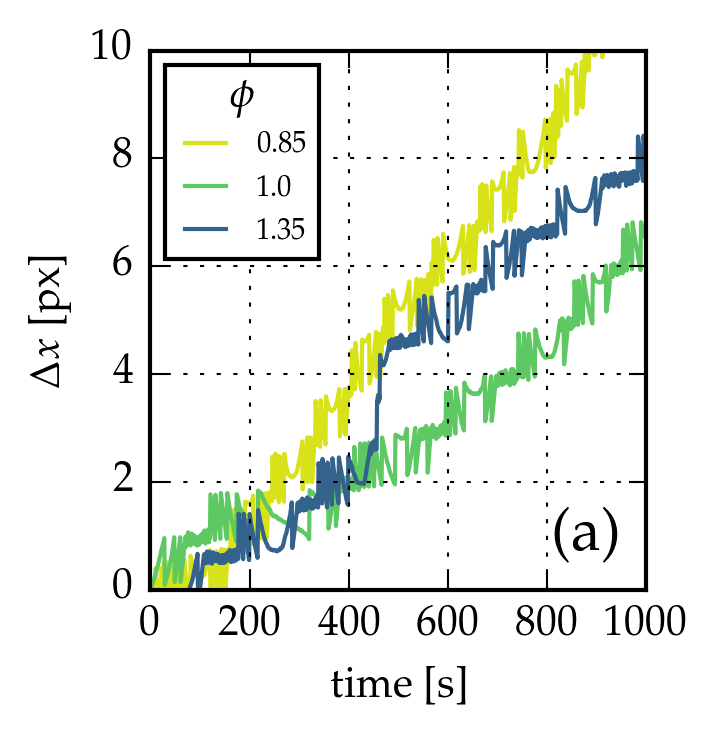

In [45]:
# figuur 1: plot particle traces, in px
# zowel initial (lijn) als bigcrop (dotted)

halffig()
t0 = 0

colors = (x for x in 'rgb')
for (phi,dataset) in sorted(datasets.items()):
    if phi not in [0.85, 1, 1.35]:
        continue
    
    color = phi_cmap(phi_norm(phi))
    particle = dataset['particle']
    plt.plot(dataset['Xpx'][:,particle] - dataset['Xpx'][t0,particle],
             color=color, label=phi)
    
plt.axis(xmin=0, xmax=1000, ymin=0, ymax=10)
plt.legend(loc='upper left', fontsize='x-small', title=r"$\phi$")
plt.xlabel("time [s]")
plt.ylabel(r"$\Delta x$ [px]")

plt.grid()

subplotlabel('(a)', loc='lower right')
plt.savefig('xpos-vs-t.pdf')

\includegraphics{notebooks/biax-particle-motion/xac-vs-t.pdf}


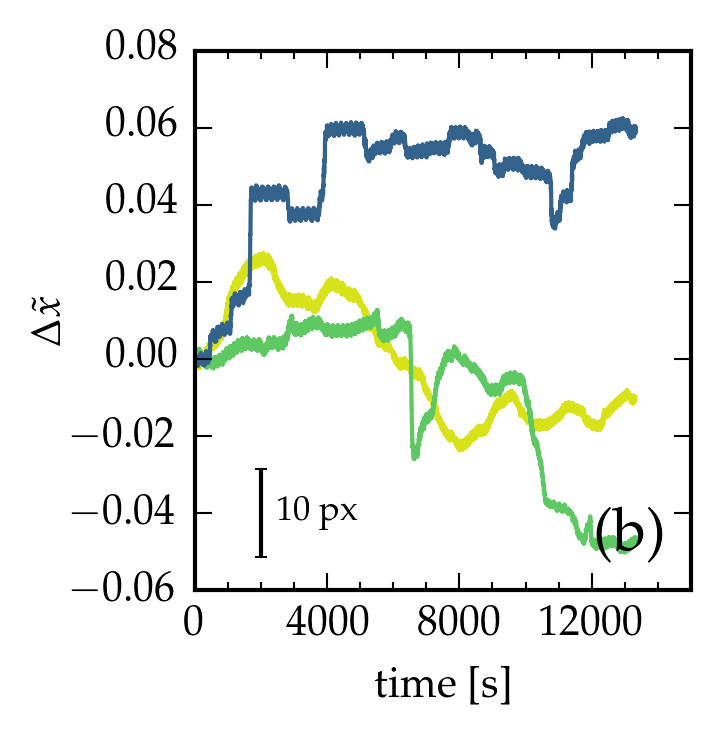

In [35]:
# figuur 1: plot particle traces, in px
# zowel initial (lijn) als bigcrop (dotted)

halffig()
t0 = 0

colors = (x for x in 'rgb')
for (phi,dataset) in sorted(datasets.items()):
    if phi not in [0.85, 1, 1.35]:
        continue
    
    color = phi_cmap(phi_norm(phi))
    particle = dataset['particle']
    plt.plot(dataset['acX'][:,particle] - dataset['acX'][t0,particle],
             color=color, label=phi)

    
scalebar = 10/np.mean(dataset['lXpx'])

#plt.plot([2000,2000], [-0.04-scalebar/2, -0.04+scalebar/2], "k", lw=2)
plt.errorbar(2000, -0.04, yerr=scalebar/2, color="k", capsize=1.5)
plt.text(2500, -0.04, "10 px", ha='left', va='center', fontsize='small')

#plt.axis(xmin=0, xmax=1000, ymin=0, ymax=10)
plt.axis(xmin=0, xmax=15000)
plt.gca().set_xticks([0,4000,8000,12000])
plt.gca().set_xticks([1000,2000,3000,5000,6000,7000,9000,10000,11000,13000,14000], minor=True)
#plt.legend(loc='lower left', fontsize='x-small', title=r"$\phi$")
plt.xlabel("time [s]")
plt.ylabel(r"$\Delta \tilde x$", labelpad=0)

subplotlabel('(b)', loc='lower right', zorder=3)

plt.savefig('xac-vs-t.pdf')


\includegraphics{notebooks/biax-particle-motion/ppos.pdf}


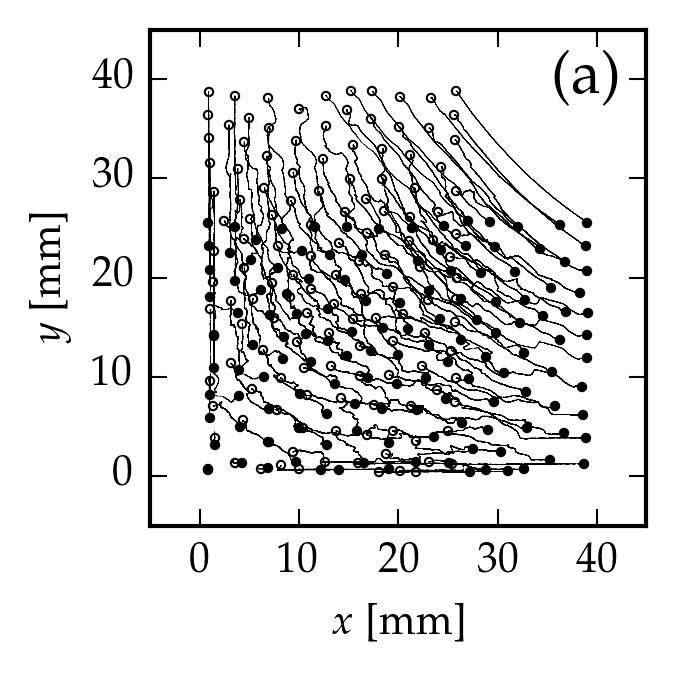

In [17]:
halffig()

dataset = datasets[0.85]

X = (dataset["Xpx"]-x0) / px_per_mm
Y = -(dataset["Ypx"]-y0) / px_per_mm

plt.subplot(111, aspect='equal')
plt.plot(X[0], Y[0], "o", ms=2, color='white', mec='black')
plt.plot(X,Y, "k", lw=0.1)

plt.plot(X[-1], Y[-1], "o", ms=2, color='black', mec='black')

plt.xlabel("$x$ [mm]")
plt.ylabel("$y$ [mm]")

plt.axis(xmin=-5, xmax=45, ymin=-5, ymax=45)

subplotlabel('(a)', loc='upper right')

plt.savefig('ppos.pdf')

\includegraphics{notebooks/biax-particle-motion/affinecorpos.pdf}


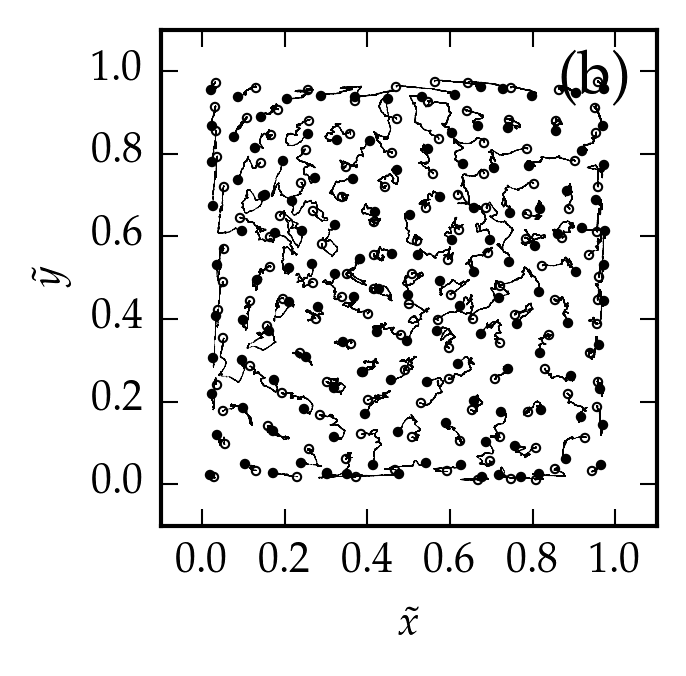

In [16]:
halffig()

dataset = datasets[0.85]
acX = dataset["acX"]
acY = dataset["acY"]

plt.subplot(111, aspect='equal')
plt.plot(acX[0], acY[0], "o", ms=2, color='white', mec='black')
plt.plot(acX,acY, "k", lw=0.1)

plt.plot(acX[-1], acY[-1], "o", ms=2, color='black', mec='black')

plt.xlabel(r"$\tilde x$")
plt.ylabel(r"$\tilde y$")

plt.axis(xmin=-0.1, xmax=1.1, ymin=-0.1, ymax=1.1)
subplotlabel('(b)', loc='upper right', zorder=3)

plt.savefig('affinecorpos.pdf')

In [36]:
def do_plot(dataset):
    size = 0.14
    
    halffig()
    plt.subplot(111, aspect='equal')

    acX = dataset["acX"]
    acY = dataset["acY"]
    particle = dataset["particle"]
    
    X = acX[:,particle]
    Y = acY[:,particle]

    lindemann = 0.14*np.nanmean(dataset["rpx"]) / np.sqrt(np.mean(dataset["lXpx"] * dataset["lYpx"]))

    colorline(X, Y, cmap=get_cmap('rainbow'), linewidth=0.5)

    plt.plot(X[0], Y[0], "o", ms=4, color='white', mec='black')
    plt.plot(X[-1], Y[-1], "o", ms=4, color='black', mec='black')

    mid_x = np.round(0.5*(np.amax(X) + np.amin(X)),2)
    mid_y = np.round(0.5*(np.amax(Y) + np.amin(Y)),2)
    
    xmin = mid_x - size/2
    xmax = mid_x + size/2
    ymin = mid_y - size/2
    ymax = mid_y + size/2
    
    plt.axis([xmin, xmax, ymin, ymax])
    
    plt.xticks([xmin, mid_x, xmax])
    plt.yticks([ymin, mid_y, ymax])
    
    plt.xlabel(r"$\tilde x$")
    plt.ylabel(r"$\tilde y$")

    # plot lindemann circle in bottom right, 2 radius from edge
    
    circle=plt.Circle((xmax - 0.01, ymin + 0.01),
                      lindemann,zorder=10,
                      facecolor='white', edgecolor='black')
    plt.gca().add_artist(circle)
    
    # plot 1 mm scalebar in top left
    # plus text '1 mm'
    
    ypos = ymin + 0.005
    xpos = xmin + 0.005
    
    l = (1 / mm_per_px) / np.mean(dataset['lXpx'])
    
    plt.plot([xpos, xpos+l], [ypos, ypos], "k")
    plt.text(xpos+l/2, ypos+0.002, "1 mm", va='bottom', ha='center', fontsize='small')
    
    sls = {0.85: '(a)', 1.0: '(b)', 1.35: '(c)'}
    if phi in sls:
        subplotlabel(sls[phi])

\includegraphics{notebooks/biax-particle-motion/caging-85.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-90.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-95.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-100.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-105.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-110.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-125.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-130.pdf}
\includegraphics{notebooks/biax-particle-motion/caging-135.pdf}


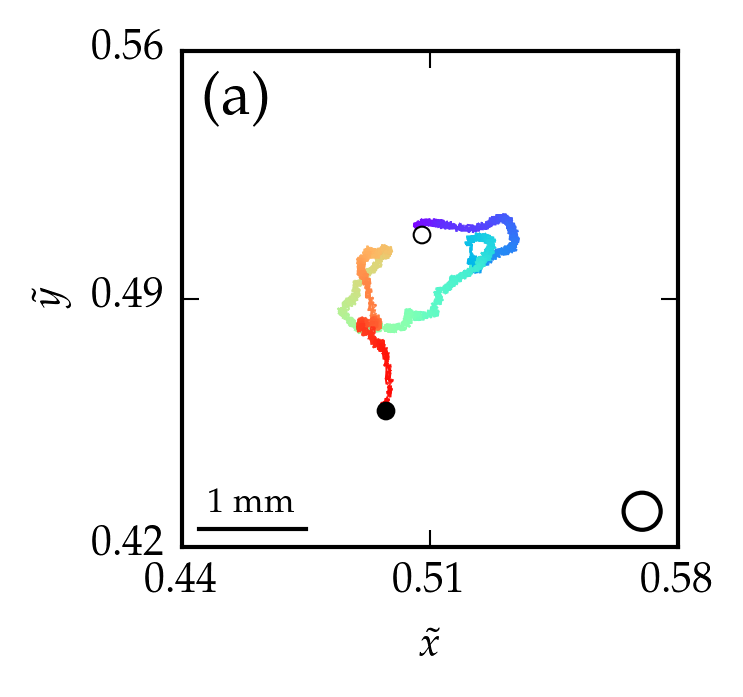

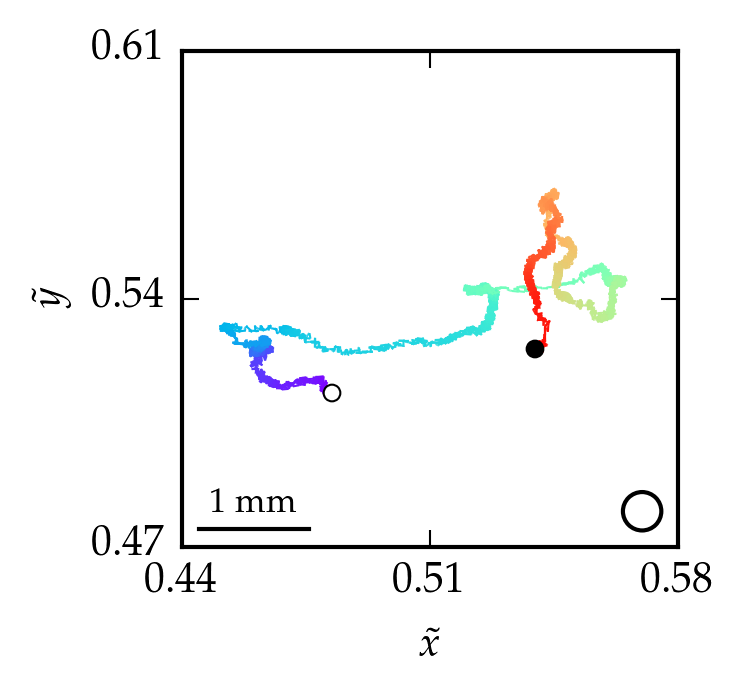

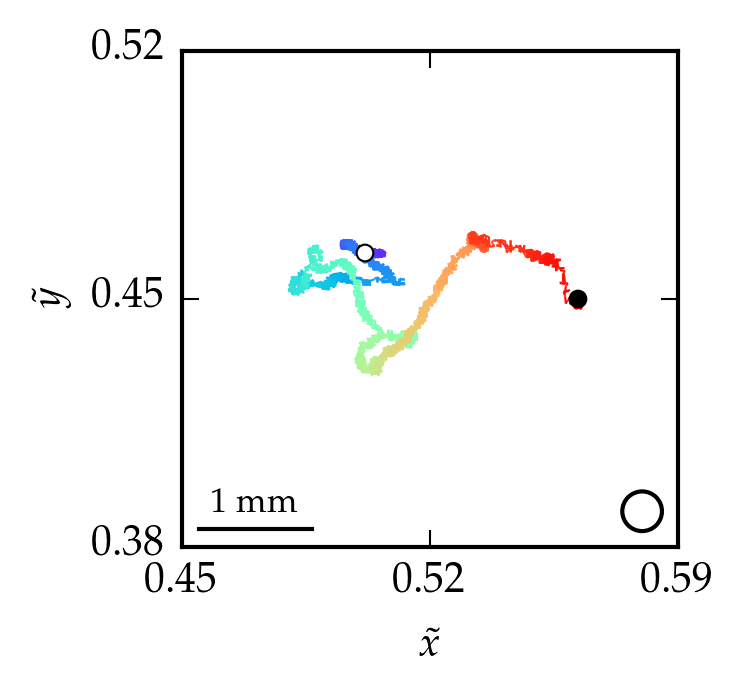

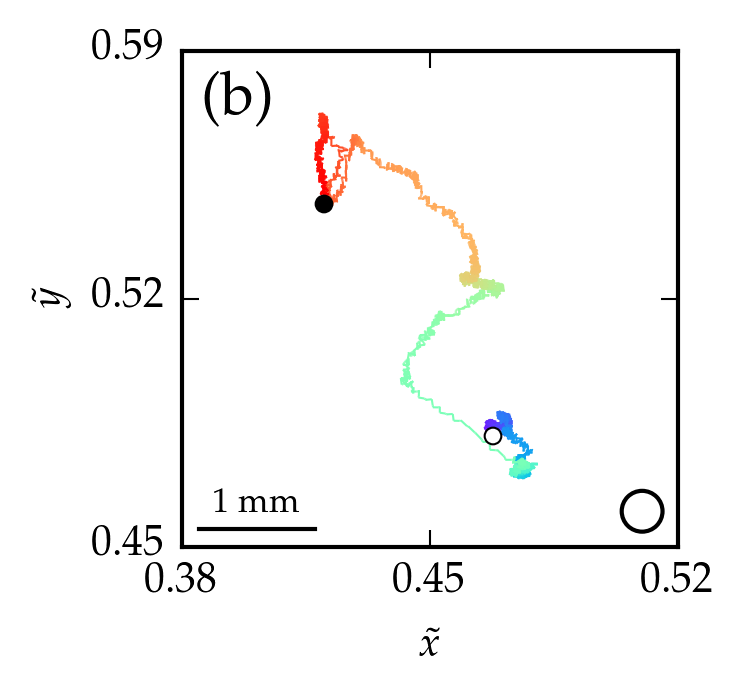

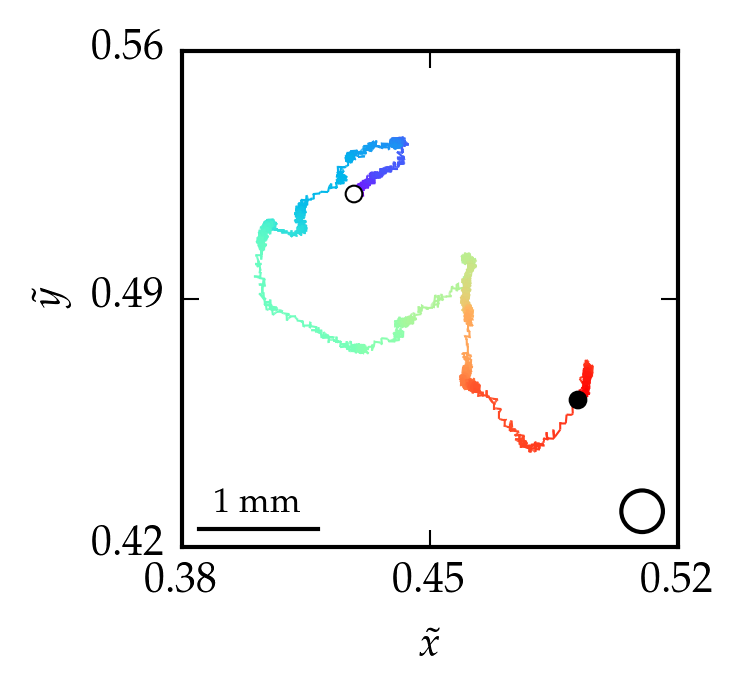

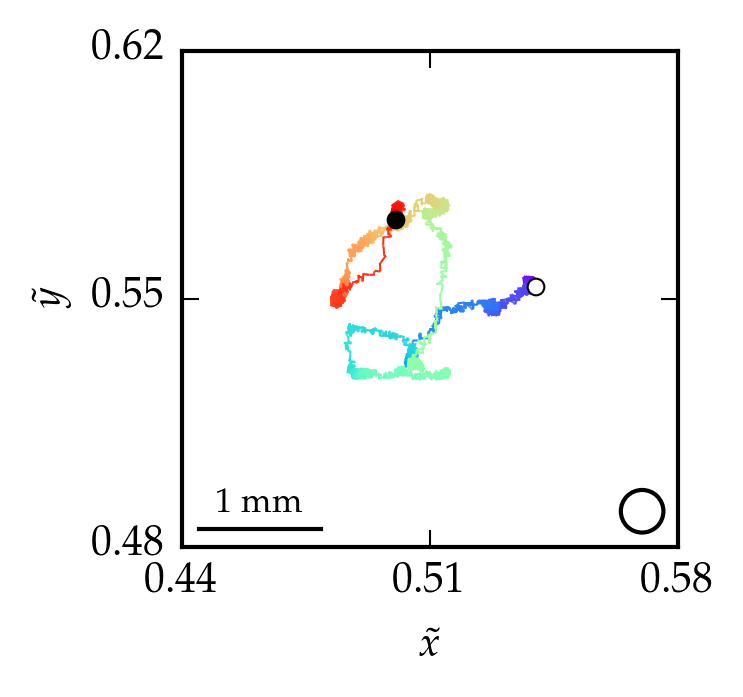

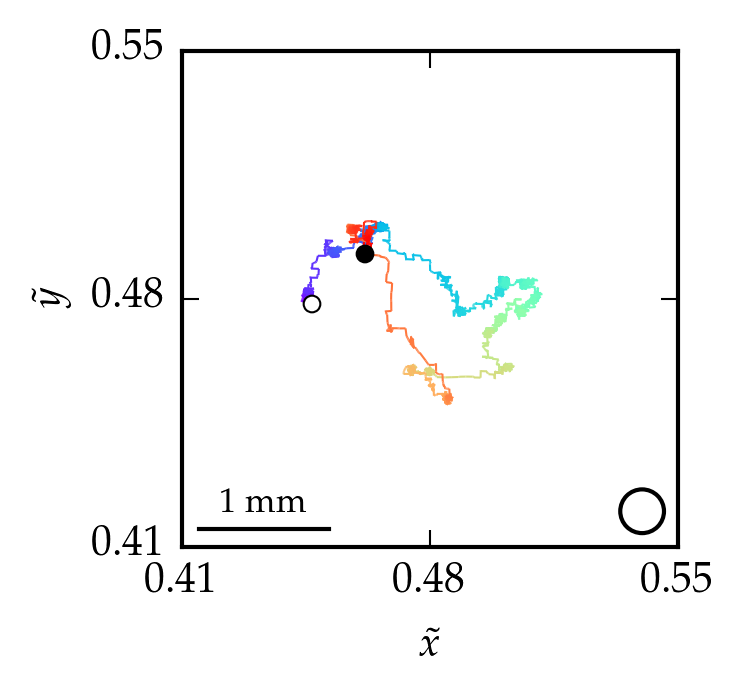

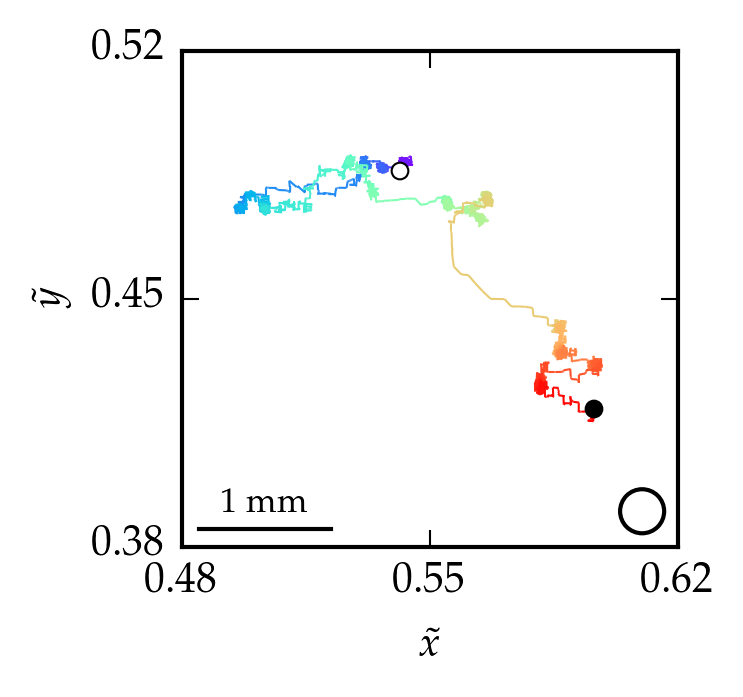

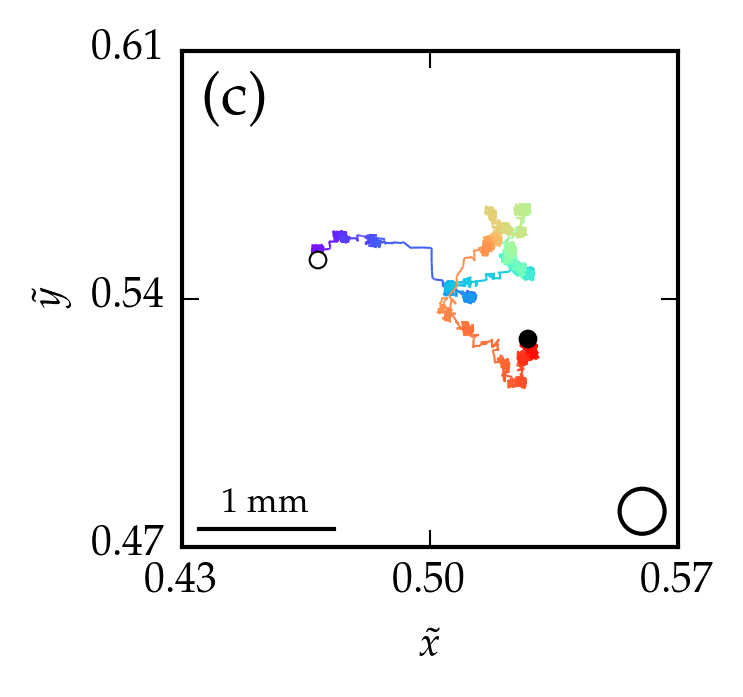

In [38]:
for phi,dataset in sorted(datasets.items()):
    do_plot(dataset)
    plt.savefig('caging-%i.pdf' % (phi*100))